# Map Validation and Repairing Tutorial
This tutorial shows how to use the map validation and repairing API. The API supports validation and repairing for one scenario, list of scenarios, and scenarios stored in directories and their subdirectories.

In [1]:
# General Imports
from commonroad.common.file_reader import CommonRoadFileReader

from crmapval.map_validator_repairer import validate_and_repair_map
from crmapval.validation.formula_ids import LaneletFormulaID

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


## Simple Validation and Repairing
General validation and repairing is shown below. All supported formulas for validation are written in *docs/tex/map_validation_repairing/z3_map_validation.pdf*.

In [2]:
import os

file_dir = os.path.join(os.getcwd(), 'files')

# Load scenario
scenario_path = os.path.join(file_dir, 'DEU_Guetersloh-20_3_T-1.xml')
scenario, _ = CommonRoadFileReader(scenario_path).open()

# Config file
config_path = os.path.join(file_dir, 'config.yaml')

# Validation and repairing based on all supported formulas
repaired_scenario, _ = validate_and_repair_map(scenario, config_path)
print('Scenario {} is validated and repaired based on all supported formulas.'.format(repaired_scenario.scenario_id))

/home/yannick/.cache/pypoetry/virtualenvs/crmapval-un_GqGOU-py3.10/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Scenario DEU_Guetersloh-20_3_T-1 is validated and repaired based on all supported formulas.


In [3]:
# Validation and repairing based on specific desired formulas
formulas = [LaneletFormulaID.POTENTIAL_LEFT_SAME_DIR_PARALLEL_ADJ, LaneletFormulaID.CONNECTIONS_PREDECESSOR]
repaired_scenario, _ = validate_and_repair_map(scenario, config_path, formulas=formulas)
print('Scenario {} is validated and repaired based on the formulas potential_predecessor and connections_predecessor.'.format(repaired_scenario.scenario_id))

Scenario DEU_Guetersloh-20_3_T-1 is validated and repaired based on the formulas potential_predecessor and connections_predecessor.


The summary of the validation and repairing process can be stored in a file.

In [4]:
# Validation and repairing with storing summary
summary_path = os.path.join(file_dir, 'summary.txt')
_ = validate_and_repair_map(scenario, config_path, formulas=formulas, summary_path=summary_path)

summary = open(summary_path, 'r').read()
print(summary)

SUMMARY 2023-05-27 11:40:43.717701 - VALIDATION AND REPAIRING OF MAP "DEU_GUETERSLOH-20_3_T-1"


Group 0:
- 'potential_left_same_dir_parallel_adj': [(72578, 72577)]

Group 0 - Iteration 0 - Error (<LaneletFormulaID.POTENTIAL_LEFT_SAME_DIR_PARALLEL_ADJ: 'potential_left_same_dir_parallel_adj'>, (72578, 72577)):
- 'potential_left_same_dir_parallel_adj': [(72578, 72577)]

Group 0 - Iteration 1 - Error (<LaneletFormulaID.POTENTIAL_LEFT_SAME_DIR_PARALLEL_ADJ: 'potential_left_same_dir_parallel_adj'>, (72578, 72577)):
{}

Group 1:
- 'connections_predecessor': [(72814, 72576)]

Group 1 - Iteration 0 - Error (<LaneletFormulaID.CONNECTIONS_PREDECESSOR: 'connections_predecessor'>, (72814, 72576)):
- 'connections_predecessor': [(72814, 72576)]

Group 1 - Iteration 1 - Error (<LaneletFormulaID.CONNECTIONS_PREDECESSOR: 'connections_predecessor'>, (72814, 72576)):
{}

Final result:
 {}



The detected invalid states can be visualized in form of a stored plotted map.

/home/yannick/Documents/HiWi/Repos/itsc2023-map-validation-code/crmapval/drawing/drawer.py:55: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r+" (-> marker='+'). The keyword argument will take precedence.
  ax.plot(point[0], point[1], color, zorder=zorder, marker=marker)


Visualizing of invalid states detected in validation of group 1:


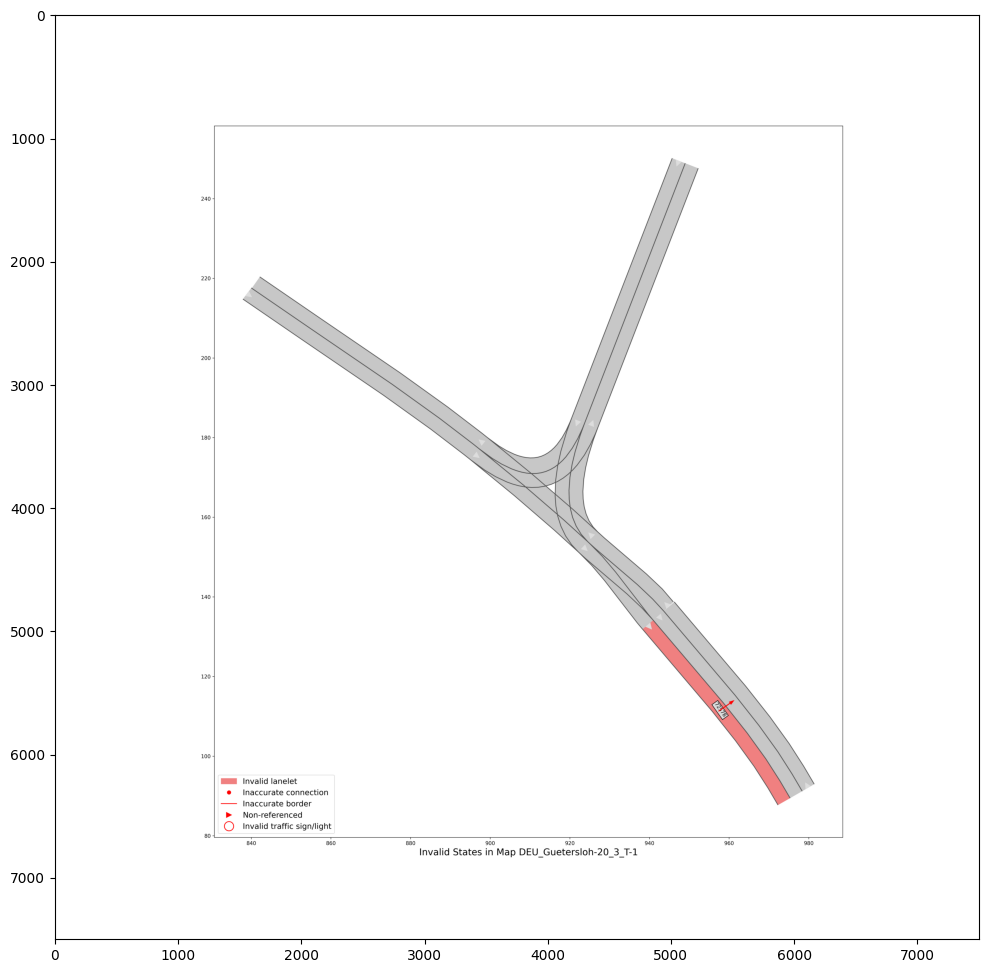

Visualizing of invalid states detected in validation of group 2:


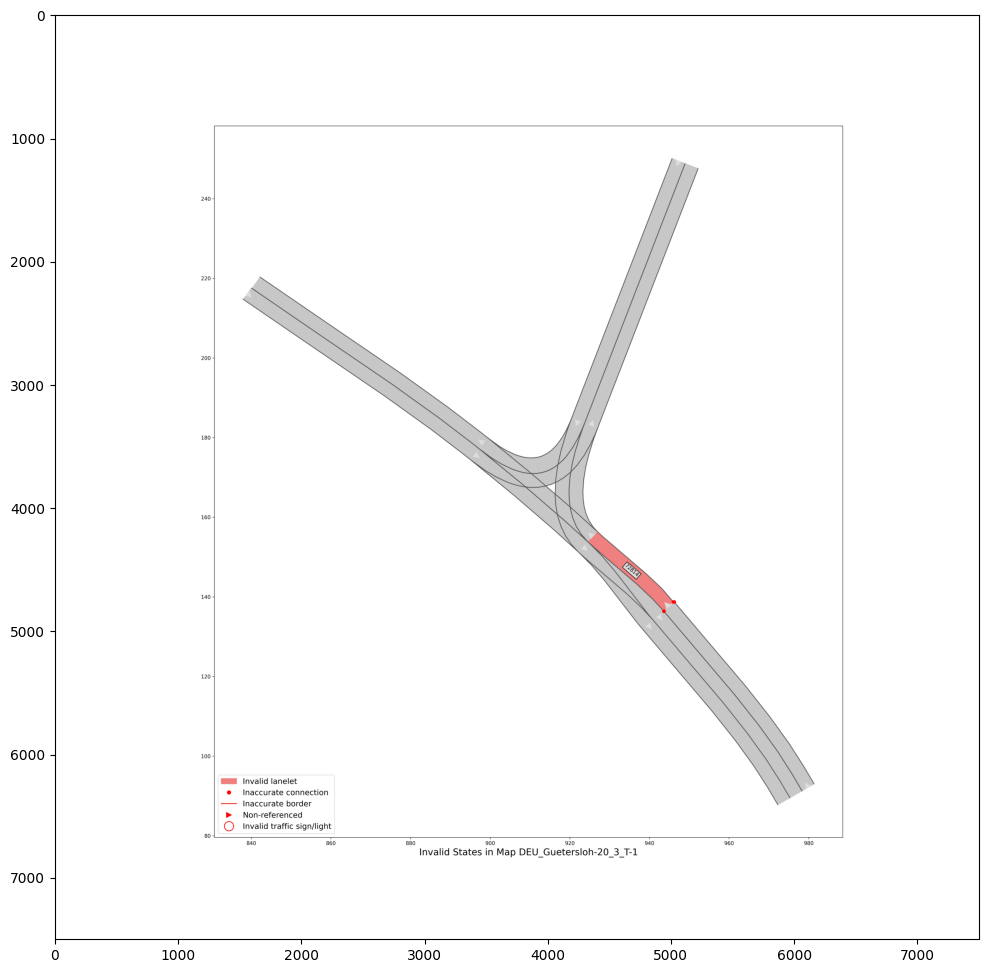

In [5]:
from matplotlib import image as mpimg, pyplot as plt

# Support visualizing of invalid states
invalid_states_draw_dir = file_dir
_ = validate_and_repair_map(scenario, config_path, formulas=formulas, invalid_states_draw_dir=invalid_states_draw_dir)

for i, plot_name in enumerate(['group_0_DEU_Guetersloh-20_3_T-1', 'group_1_DEU_Guetersloh-20_3_T-1']):
    print('Visualizing of invalid states detected in validation of group {}:'.format(i + 1))
    plt.figure(figsize=(12, 12))
    img = mpimg.imread(os.path.join(invalid_states_draw_dir, plot_name + '.png'))
    plt.imshow(img)
    plt.show()

## Advanced Validation and Repairing
For large maps partitioning is strongly recommended. Each partition can be validated separately and parallelized.

In [6]:
import os

file_dir = os.path.join(os.getcwd(), 'files')

# Load scenario
scenario_path = os.path.join(file_dir, 'DEU_BadEssen-3_1_T-1.xml')
scenario, _ = CommonRoadFileReader(scenario_path).open()

# Config file
config_path = os.path.join(file_dir, 'config.yaml')

# Choose partitioning and number of maximal processes
repaired_scenario, _ = validate_and_repair_map(scenario, config_path, partitioned=True, max_processes=4)
print('Scenario {} is validated and repaired with partitioning.'.format(repaired_scenario.scenario_id))

Scenario DEU_BadEssen-3_1_T-1 is validated and repaired with partitioning.


The partitions can be visualized in form of a stored plot.

Visualizing of partition for lanelet formulas:


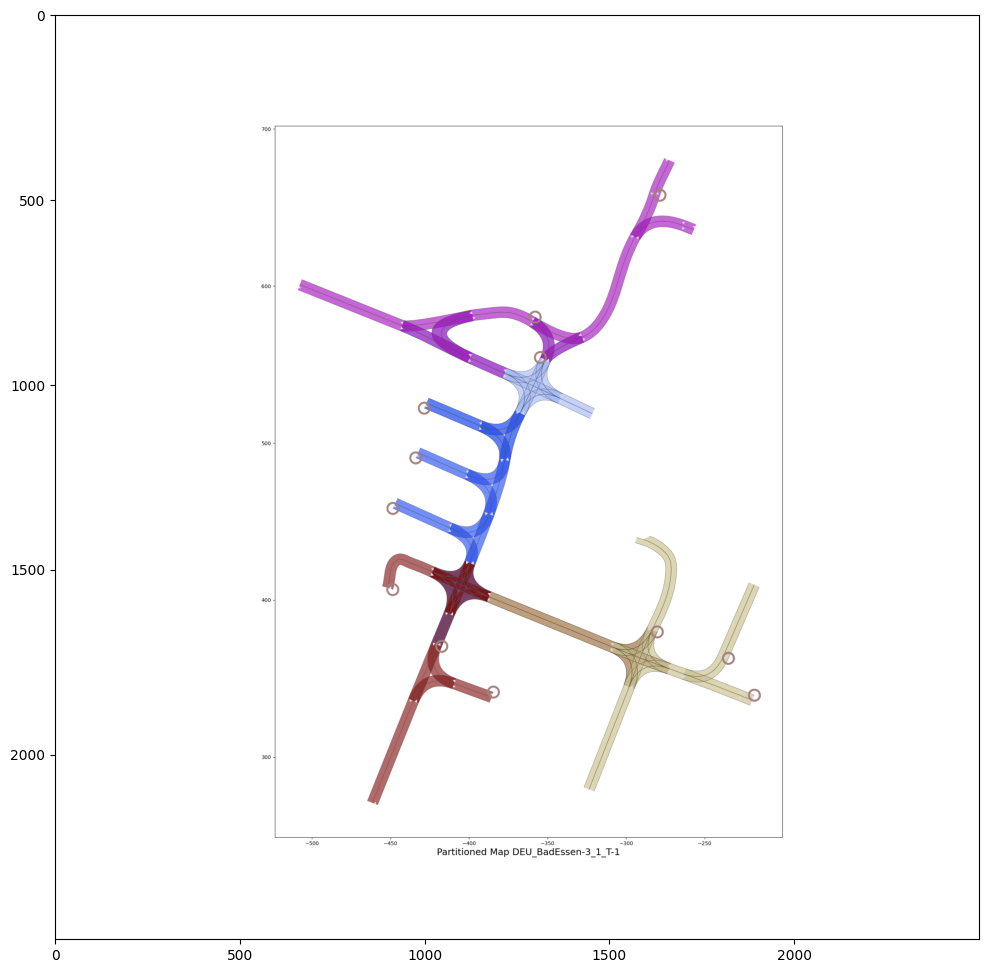

In [7]:
# Support visualizing of invalid states
_ = validate_and_repair_map(scenario, config_path, partitioned=True, max_processes=4, partition_draw_dir=file_dir)

print('Visualizing of partition for lanelet formulas:')
plt.figure(figsize=(12, 12))
img = mpimg.imread(os.path.join(file_dir, 'LaneletPartition-DEU_BadEssen-3_1_T-1.png'))
plt.imshow(img)
plt.show()

For validation the solvers clingo (ASP) and Z3 (SMT) are supported. Compared to Z3, ASP is significantly more performant, and therefore it is recommended to use ASP. ASP is already used by default.

The information during validation and repairing is recorded and can be viewed. The validation result can also be saved to a protobuf file and read out again.

In [8]:
from crmapval.evaluation.validation_result_io import ValidationResultWriter, \
    ValidationResultReader

_, validation_result = validate_and_repair_map(scenario, config_path, partitioned=True, max_processes=4)

# store validation result in protobuf file
validation_result_path = os.path.join(file_dir, 'validation_result.pb')
validation_result_writer = ValidationResultWriter(validation_result_path)
validation_result_writer.write_validation_result(validation_result)

# read validation result from protobuf file
validation_result_reader = ValidationResultReader(validation_result_path)
validation_result = validation_result_reader.read_validation_result()

# print some information of validation result
map_validation = validation_result.map_validations[0]
print('Validation result of', map_validation.benchmark_id, 'with [ max_iterations =', map_validation.max_iterations,
      ', max_processes =', map_validation.max_processes, ', partitioned =', map_validation.partitioned,
      ', solver =', map_validation.solver, ']:')

Validation result of DEU_BadEssen-3_1_T-1 with [ max_iterations = 5 , max_processes = 4 , partitioned = True , solver = Solver.ASP ]:


Information of the validation result can be visualized. There are supported plots for the computation times, the invalid states, and validation parameters.

Visualization of computation times:


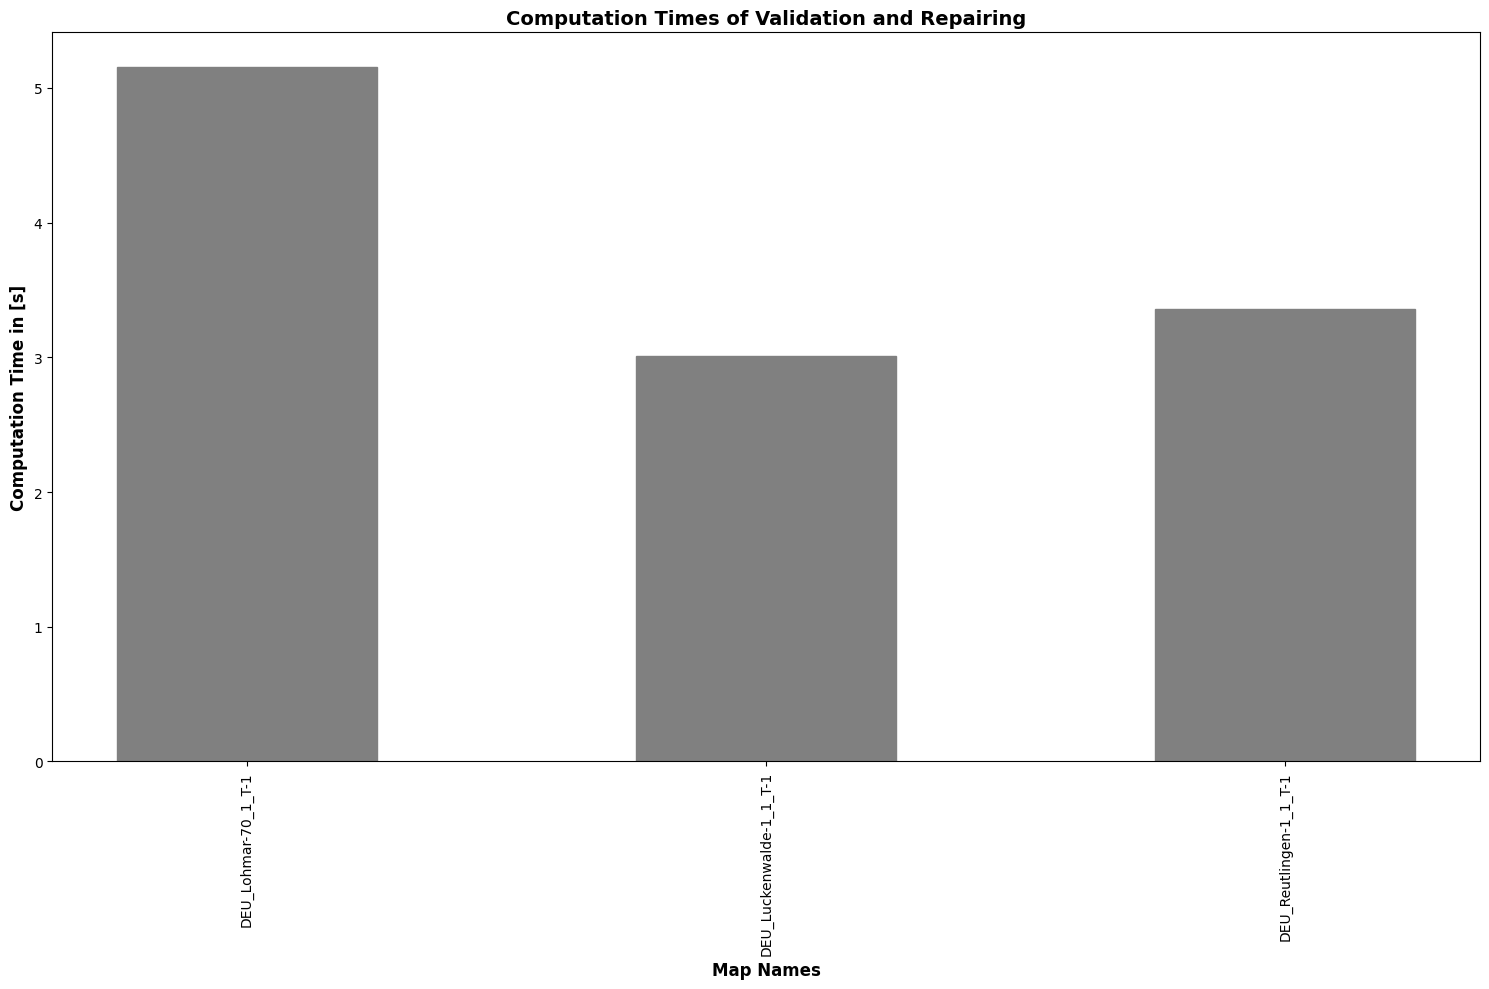

Visualization of initial invalid states:


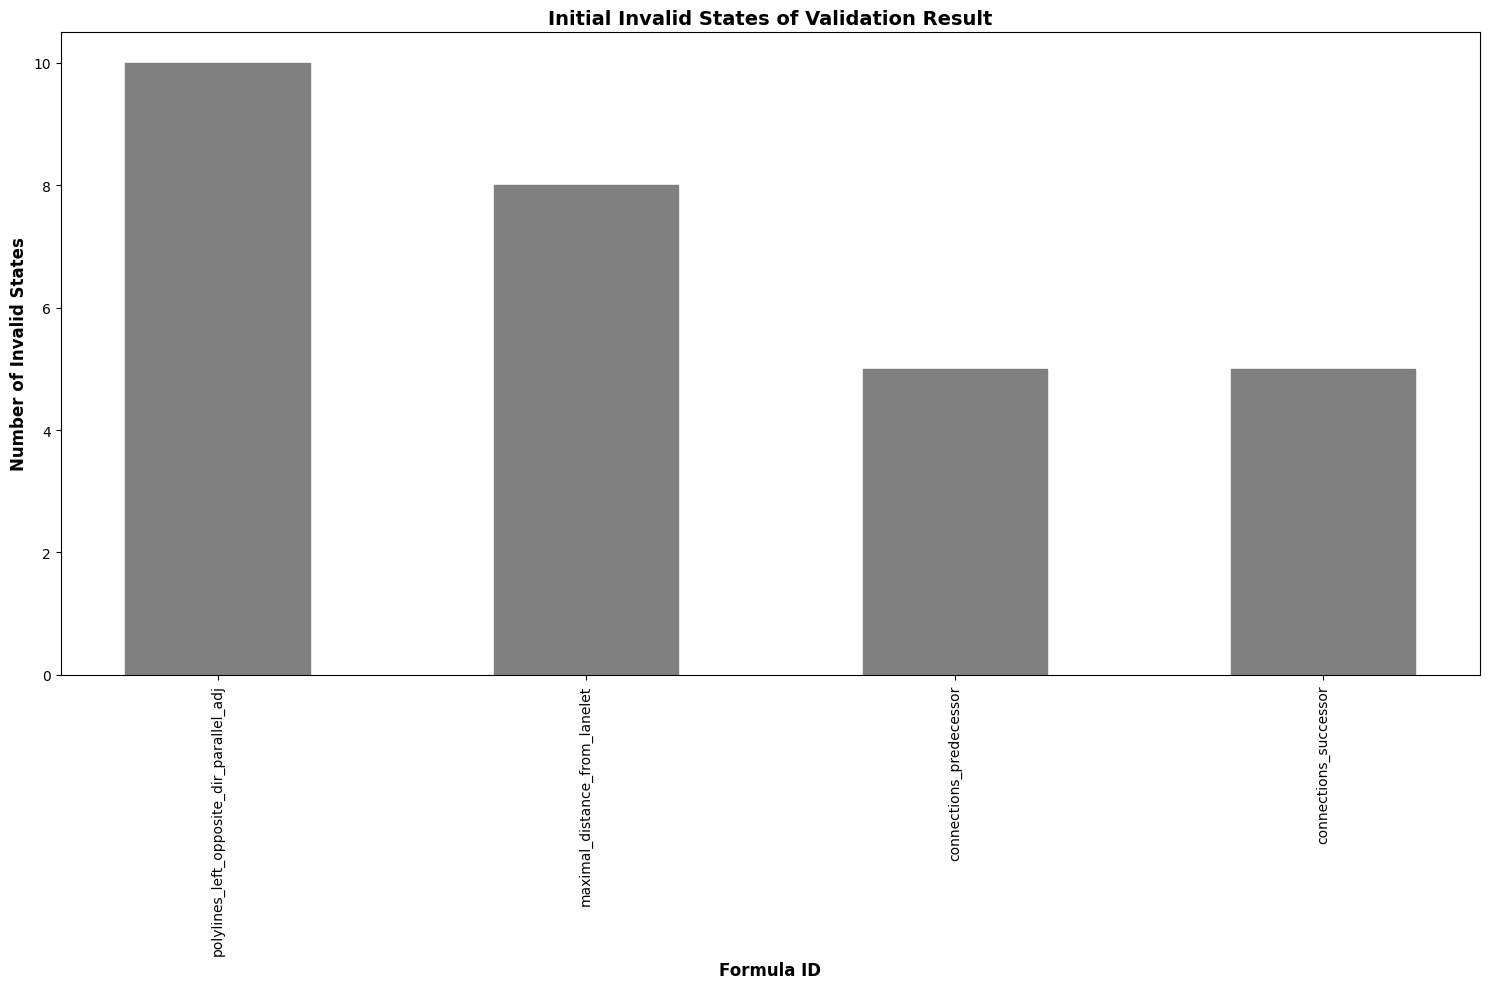

Visualization of validation parameters:


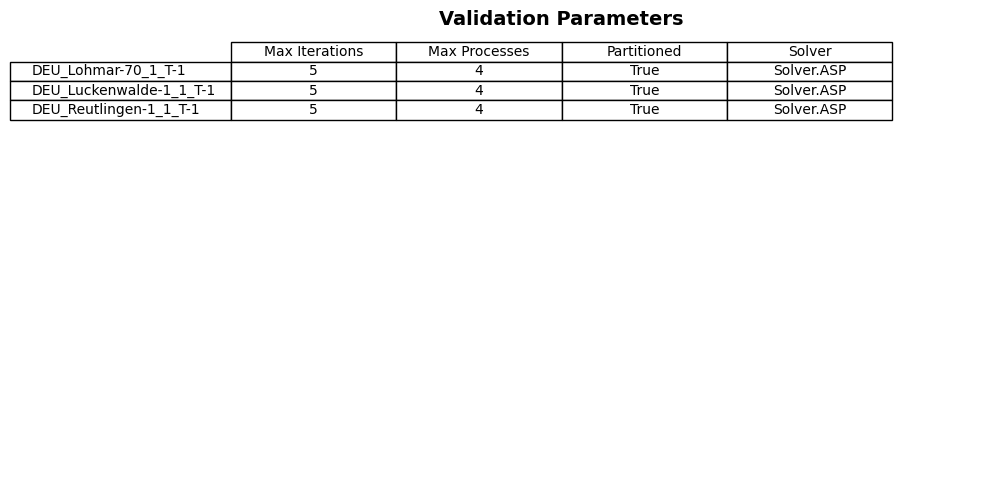

In [9]:
from crmapval.evaluation.evaluation import ValidationResultVisualizer
from crmapval.map_validator_repairer import validate_and_repair_maps

scenario_files = ['DEU_Lohmar-70_1_T-1.xml', 'DEU_Luckenwalde-1_1_T-1.xml', 'DEU_Reutlingen-1_1_T-1.xml']

# load scenarios
scenarios = []
for scenario_file in scenario_files:
    scenario, _ = CommonRoadFileReader(os.path.join(file_dir, scenario_file)).open()
    scenarios.append(scenario)

# validate and repair the loaded scenarios
_, validation_result = validate_and_repair_maps(scenarios, config_path, partitioned=True, max_processes=4)

# initialize visualizer for validation result
visualizer = ValidationResultVisualizer(validation_result)

# visualize computation times
print('Visualization of computation times:')
visualizer.plot_computation_times()

# visualize initial invalid states
print('Visualization of initial invalid states:')
visualizer.plot_invalid_states()

# visualize validation parameters
print('Visualization of validation parameters:')
visualizer.plot_validation_parameters()